In [ ]:
# print('c6h6 energy: -230.7911477999069')
# print('h8 energy: -4.336065651809496')
# print('ch2 energy: -38.808995464755355')
# print('lih energy: -7.97233558238377')
print('beh2 energy: -15.650687261090678')
# print('h2o energy: -75.59903648548807')
# print('o2 energy: -148.8881375280719')
# print('n2 energy: -108.51430124074876')
print('butadiene energy: -154.419405817906')
print('cyclobutadiene energy: -153.429717423110')

sys_str = "butadiene"
reference_energy = -154.419405817906

sys_str = "cyclobutadiene"
reference_energy = -153.429717423110

sys_str = "beh2"
reference_energy = -15.650687261090678

c6h6 energy: -230.7911477999069
h8 energy: -4.336065651809496
ch2 energy: -38.808995464755355
lih energy: -7.97233558238377
beh2 energy: -15.650687261090678
h2o energy: -75.59903648548807
o2 energy: -148.8881375280719
n2 energy: -108.51430124074876
butadiene energy: -154.419405817906
cyclobutadiene energy: -153.429717423110


Skipping VQE due to invalid log data.
Skipping PQE due to invalid log data.
Saved figure as figures/shots_vs_dE_iter25_butadiene_ppqe_vqe_pqe_ht.pdf


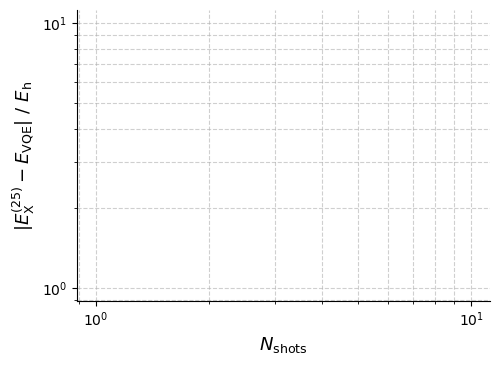

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from collections import defaultdict
import os

def is_valid_log_data(x_vals, y_vals):
    return all(x > 0 and np.isfinite(x) for x in x_vals) and \
           all(y > 0 and np.isfinite(y) for y in y_vals)

# --- User options ---
sys_str = "butadiene"
reference_energy = -154.419405817906

n_iter = 25  # Which iteration to analyze (1-based)
n_iter_vqe = 25  # Which iteration to analyze (1-based)
n_iter_pqe = 25  # Which iteration to analyze (1-based)

include_dt = [1.0e-2]
include_update_types = ['jl', 'tlr', 'tlrim']


include_noise_factors = [1.0e-8, 1.0e-7, 1.0e-6, 1.0e-5, 1.0e-4]
include_vqe_noise_factors = [1.0e-5, 1.0e-4, 1.0e-3, 1.0e-2]
include_pqe_noise_factors = [1.0e-5, 1.0e-4, 1.0e-3, 1.0e-2]

color_list = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]

vqe_color = 'black'

pqe_color = 'gray'

update_types = {
    'jl':   {'label': 'Jacobi-like',           'linestyle': 'solid'},
    'tlr':  {'label': 'Two-level rotation',    'linestyle': 'dashed'},
    'tlrim':{'label': 'Two-level rotation (im)','linestyle': 'dotted'},
}
all_update_types = ['jl', 'tlr', 'tlrim']
if include_update_types is None:
    plot_update_types = all_update_types
else:
    plot_update_types = [ut for ut in include_update_types if ut in all_update_types]

dt_pattern = re.compile(r"dt_([0-9.eE+-]+)")
update_pattern = re.compile(r"updt_([a-z]+)")
noise_pattern = re.compile(r"noise_([0-9.eE+-]+)")
r_pattern = re.compile(r"r_(\d+)")

vqe_noise_pattern = re.compile(r"noise_([0-9.eE+-]+)")
vqe_r_pattern = re.compile(r"r_(\d+)")

pqe_noise_pattern = re.compile(r"noise_([0-9.eE+-]+)")
pqe_r_pattern = re.compile(r"r_(\d+)")

# --- Gather all PPQE files ---
all_files = glob.glob(f"ppqe_noisy_runs_data/{sys_str}/ppqe_{sys_str}_dt_*_updt_*_noise_*_r_*.dat")
data = defaultdict(lambda: {ut: defaultdict(lambda: defaultdict(list)) for ut in plot_update_types})

for fname in all_files:
    dt_m = dt_pattern.search(fname)
    update_m = update_pattern.search(fname)
    noise_m = noise_pattern.search(fname)
    r_m = r_pattern.search(fname)
    if not (dt_m and update_m and noise_m and r_m):
        continue
    dt = float(dt_m.group(1))
    update_type = update_m.group(1)
    noise = float(noise_m.group(1))
    run = int(r_m.group(1))
    if include_dt is not None and dt not in include_dt:
        continue
    if update_type not in plot_update_types:
        continue
    if include_noise_factors is not None and noise not in include_noise_factors:
        continue
    with open(fname, "r") as f:
        lines = [line for line in f if not line.strip().startswith("#") and line.strip()]
    arr = np.loadtxt(lines)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    if arr.shape[0] < n_iter:
        continue
    dE_n = np.abs(arr[n_iter-1, 1] - reference_energy)
    nshots_n = arr[n_iter-1, -1]
    data[dt][update_type][noise][run].append((dE_n, nshots_n))

# --- Gather all VQE files ---
vqe_files = glob.glob(f"vqe_noisy_runs_data/{sys_str}/vqe_{sys_str}_pool_SD_gtol_*_ndiis_*_updt_BFGS_noise_*_r_*.dat")
vqe_data = defaultdict(lambda: defaultdict(list))  # vqe_data[noise][run] = (dE, nshots)

for fname in vqe_files:
    noise_m = vqe_noise_pattern.search(fname)
    r_m = vqe_r_pattern.search(fname)
    if not (noise_m and r_m):
        continue
    noise = float(noise_m.group(1))
    run = int(r_m.group(1))
    if include_vqe_noise_factors is not None and noise not in include_vqe_noise_factors:
        continue
    with open(fname, "r") as f:
        lines = [line for line in f if not line.strip().startswith("#") and line.strip()]
    arr = np.loadtxt(lines)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    if arr.shape[0] < n_iter_vqe:
        continue
    dE_n = np.abs(arr[n_iter_vqe-1, 1] - reference_energy)
    nshots_n = arr[n_iter_vqe-1, -1]
    vqe_data[noise][run] = (dE_n, nshots_n)


# --- Gather all PQE files ---
pqe_files = glob.glob(f"pqe_noisy_runs_data/{sys_str}/pqe_{sys_str}_pool_SD_gtol_*_ndiis_*_updt_BFGS_noise_*_r_*.dat")
pqe_data = defaultdict(lambda: defaultdict(list))  # pqe_data[noise][run] = (dE, nshots)

for fname in pqe_files:
    noise_m = pqe_noise_pattern.search(fname)
    r_m = pqe_r_pattern.search(fname)
    if not (noise_m and r_m):
        continue
    noise = float(noise_m.group(1))
    run = int(r_m.group(1))
    if include_pqe_noise_factors is not None and noise not in include_pqe_noise_factors:
        continue
    with open(fname, "r") as f:
        lines = [line for line in f if not line.strip().startswith("#") and line.strip()]
    arr = np.loadtxt(lines)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    if arr.shape[0] < n_iter_pqe:
        continue
    dE_n = np.abs(arr[n_iter_pqe-1, 1] - reference_energy)
    nshots_n = arr[n_iter_pqe-1, -1]
    pqe_data[noise][run] = (dE_n, nshots_n)




# --- Plot PPQE, VQE and PQE ---
# plt.figure(figsize=(8, 5))
plt.figure(figsize=(5.1, 3.75))
dt_vals = sorted(data.keys())
dt_to_color = {dt: color_list[i % len(color_list)] for i, dt in enumerate(dt_vals)}

# --- Plot PPQE ---
for dt in dt_vals:
    color = dt_to_color[dt]
    for ut in plot_update_types:
        noise_vals = sorted(data[dt][ut].keys())
        if not noise_vals:
            continue
        avg_nshots_list = []
        std_nshots_list = []
        avg_dEs = []
        std_dEs = []
        for noise in noise_vals:
            runs = data[dt][ut][noise]
            dEs = [runs[run][0][0] for run in runs if runs[run]]
            nshots = [runs[run][0][1] for run in runs if runs[run]]
            if not dEs or not nshots:
                continue
            avg_dEs.append(np.mean(dEs))
            std_dEs.append(np.std(dEs))
            avg_nshots_list.append(np.mean(nshots))
            std_nshots_list.append(np.std(nshots))

        if avg_nshots_list and is_valid_log_data(avg_nshots_list, avg_dEs):
            label = f"PPQE: $\Delta t$={dt:.2e}, {update_types[ut]['label']}"
            plt.errorbar(
                avg_nshots_list, 
                avg_dEs,
                # xerr=std_nshots_list, 
                yerr=std_dEs,
                marker='o',
                linestyle=update_types[ut]['linestyle'],
                color=color,
                label=label,
                capsize=3
            )
        else:
            print(f"Skipping PPQE: dt={dt}, update={ut} due to invalid log data.")

# --- Plot VQE ---
avg_nshots_list_vqe = []
std_nshots_list_vqe = []
avg_dEs_vqe = []
std_dEs_vqe = []

for noise in sorted(vqe_data.keys()):
    runs = vqe_data[noise]
    dEs = [runs[run][0] for run in runs if runs[run]]
    nshots = [runs[run][1] for run in runs if runs[run]]
    if not dEs or not nshots:
        continue
    avg_dE = np.mean(dEs)
    std_dE = np.std(dEs)
    avg_nshot = np.mean(nshots)
    std_nshot = np.std(nshots)
    label = f"VQE: noise={noise:.1e}"
    avg_dEs_vqe.append(np.mean(dEs))
    std_dEs_vqe.append(np.std(dEs))
    avg_nshots_list_vqe.append(np.mean(nshots))
    std_nshots_list_vqe.append(np.std(nshots))

if avg_nshots_list_vqe and is_valid_log_data(avg_nshots_list_vqe, avg_dEs_vqe):
    plt.errorbar(
        avg_nshots_list_vqe, 
        avg_dEs_vqe,
        # xerr=[std_nshot], 
        yerr=std_dEs_vqe,
        marker='s',
        linestyle='dashdot',
        color=vqe_color,
        label=label,
        capsize=3
    )
else:
    print("Skipping VQE due to invalid log data.")

# --- Plot PQE ---
avg_nshots_list_pqe = []
std_nshots_list_pqe = []
avg_dEs_pqe = []
std_dEs_pqe = []

for noise in sorted(pqe_data.keys()):
    runs = pqe_data[noise]
    dEs = [runs[run][0] for run in runs if runs[run]]
    nshots = [runs[run][1] for run in runs if runs[run]]
    if not dEs or not nshots:
        continue
    avg_dE = np.mean(dEs)
    std_dE = np.std(dEs)
    avg_nshot = np.mean(nshots)
    std_nshot = np.std(nshots)
    label = f"PQE: noise={noise:.1e}"
    avg_dEs_pqe.append(np.mean(dEs))
    std_dEs_pqe.append(np.std(dEs))
    avg_nshots_list_pqe.append(np.mean(nshots))
    std_nshots_list_pqe.append(np.std(nshots))

if avg_nshots_list_pqe and is_valid_log_data(avg_nshots_list_pqe, avg_dEs_pqe):
    plt.errorbar(
        avg_nshots_list_pqe, 
        avg_dEs_pqe,
        # xerr=[std_nshot], 
        yerr=std_dEs_pqe,
        marker='^',
        linestyle='dashdot',
        color=pqe_color,
        label=label,
        capsize=3
    )
else:
    print("Skipping PQE due to invalid log data.")

# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel("Average Number of Shots (over runs)", fontsize=13)
# plt.ylabel(r"Average $|E - E_{\rm ref}|$ at iter %d (mean $\pm$ std over runs)" % n_iter, fontsize=13)
# # plt.title(f"PPQE & VQE: Shots vs. Energy Error (iter {n_iter}) for {sys_str.upper()}", fontsize=14)
# plt.grid(True, which='both', ls='--', alpha=0.6)
# plt.tight_layout()
# plt.legend(fontsize=8, loc='best', ncol=2)

plt.xscale('log')
plt.yscale('log')

plt.xlabel("$N_\mathrm{shots}$", fontsize=13)
plt.ylabel("$|E_\mathrm{X}^{(25)} - E_\mathrm{VQE}| ~/ ~E_\mathrm{h}$", fontsize=13)

plt.grid(True, which='both', ls='--', alpha=0.6)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

# --- Save figure ---
os.makedirs("figures", exist_ok=True)
output_pdf = f"figures/shots_vs_dE_iter{n_iter}_{sys_str}_ppqe_vqe_pqe_ht.pdf"
plt.savefig(output_pdf)
print(f"Saved figure as {output_pdf}")

plt.show()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from collections import defaultdict
import os

# --- User options ---
sys_str = "beh2"
reference_energy = -15.650687261090678

n_iter = 25  # Which iteration to analyze (1-based)
n_iter_vqe = 25  # Which iteration to analyze (1-based)
n_iter_pqe = 25  # Which iteration to analyze (1-based)

include_dt = [1.0e-2]
include_update_types = ['jl', 'tlr', 'tlrim']


include_noise_factors = [1.0e-8, 1.0e-7, 1.0e-6, 1.0e-5, 1.0e-4]
include_vqe_noise_factors = [1.0e-5, 1.0e-4, 1.0e-3, 1.0e-2]
include_pqe_noise_factors = [1.0e-5, 1.0e-4, 1.0e-3, 1.0e-2, 1.0e-1]

color_list = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]

vqe_color = 'black'

pqe_color = 'gray'

update_types = {
    'jl':   {'label': 'Jacobi-like',           'linestyle': 'solid'},
    'tlr':  {'label': 'Two-level rotation',    'linestyle': 'dashed'},
    'tlrim':{'label': 'Two-level rotation (im)','linestyle': 'dotted'},
}
all_update_types = ['jl', 'tlr', 'tlrim']
if include_update_types is None:
    plot_update_types = all_update_types
else:
    plot_update_types = [ut for ut in include_update_types if ut in all_update_types]

dt_pattern = re.compile(r"dt_([0-9.eE+-]+)")
update_pattern = re.compile(r"updt_([a-z]+)")
noise_pattern = re.compile(r"noise_([0-9.eE+-]+)")
r_pattern = re.compile(r"r_(\d+)")

vqe_noise_pattern = re.compile(r"noise_([0-9.eE+-]+)")
vqe_r_pattern = re.compile(r"r_(\d+)")

pqe_noise_pattern = re.compile(r"noise_([0-9.eE+-]+)")
pqe_r_pattern = re.compile(r"r_(\d+)")

# --- Gather all PPQE files ---
all_files = glob.glob(f"ppqe_noisy_runs_data/{sys_str}/ppqe_{sys_str}_dt_*_updt_*_noise_*_r_*.dat")
data = defaultdict(lambda: {ut: defaultdict(lambda: defaultdict(list)) for ut in plot_update_types})

for fname in all_files:
    dt_m = dt_pattern.search(fname)
    update_m = update_pattern.search(fname)
    noise_m = noise_pattern.search(fname)
    r_m = r_pattern.search(fname)
    if not (dt_m and update_m and noise_m and r_m):
        continue
    dt = float(dt_m.group(1))
    update_type = update_m.group(1)
    noise = float(noise_m.group(1))
    run = int(r_m.group(1))
    if include_dt is not None and dt not in include_dt:
        continue
    if update_type not in plot_update_types:
        continue
    if include_noise_factors is not None and noise not in include_noise_factors:
        continue
    with open(fname, "r") as f:
        lines = [line for line in f if not line.strip().startswith("#") and line.strip()]
    arr = np.loadtxt(lines)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    if arr.shape[0] < n_iter:
        continue
    dE_n = np.abs(arr[n_iter-1, 1] - reference_energy)

    # ===> Get updated PPQE shot count estimate based on 1/eps 
    # instead of 1/eps^2
    nshots_n = arr[n_iter-1, -1] * noise

    data[dt][update_type][noise][run].append((dE_n, nshots_n))

# --- Gather all VQE files ---
vqe_files = glob.glob(f"vqe_noisy_runs_data/{sys_str}/vqe_{sys_str}_pool_SD_gtol_*_ndiis_*_updt_BFGS_noise_*_r_*.dat")
vqe_data = defaultdict(lambda: defaultdict(list))  # vqe_data[noise][run] = (dE, nshots)

for fname in vqe_files:
    noise_m = vqe_noise_pattern.search(fname)
    r_m = vqe_r_pattern.search(fname)
    if not (noise_m and r_m):
        continue
    noise = float(noise_m.group(1))
    run = int(r_m.group(1))
    if include_vqe_noise_factors is not None and noise not in include_vqe_noise_factors:
        continue
    with open(fname, "r") as f:
        lines = [line for line in f if not line.strip().startswith("#") and line.strip()]
    arr = np.loadtxt(lines)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    if arr.shape[0] < n_iter_vqe:
        continue
    dE_n = np.abs(arr[n_iter_vqe-1, 1] - reference_energy)
    nshots_n = arr[n_iter_vqe-1, -1]
    vqe_data[noise][run] = (dE_n, nshots_n)


# --- Gather all PQE files ---
pqe_files = glob.glob(f"pqe_noisy_runs_data/{sys_str}/pqe_{sys_str}_pool_SD_gtol_*_ndiis_*_updt_BFGS_noise_*_r_*.dat")
pqe_data = defaultdict(lambda: defaultdict(list))  # pqe_data[noise][run] = (dE, nshots)

for fname in pqe_files:
    noise_m = pqe_noise_pattern.search(fname)
    r_m = pqe_r_pattern.search(fname)
    if not (noise_m and r_m):
        continue
    noise = float(noise_m.group(1))
    run = int(r_m.group(1))
    if include_pqe_noise_factors is not None and noise not in include_pqe_noise_factors:
        continue
    with open(fname, "r") as f:
        lines = [line for line in f if not line.strip().startswith("#") and line.strip()]
    arr = np.loadtxt(lines)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    if arr.shape[0] < n_iter_pqe:
        continue
    dE_n = np.abs(arr[n_iter_pqe-1, 1] - reference_energy)
    nshots_n = arr[n_iter_pqe-1, -1]
    pqe_data[noise][run] = (dE_n, nshots_n)




# --- Plot PPQE, VQE and PQE ---
# plt.figure(figsize=(8, 5))
plt.figure(figsize=(5.1, 3.75))
dt_vals = sorted(data.keys())
dt_to_color = {dt: color_list[i % len(color_list)] for i, dt in enumerate(dt_vals)}

# --- Plot PPQE ---
for dt in dt_vals:
    color = dt_to_color[dt]
    for ut in plot_update_types:
        noise_vals = sorted(data[dt][ut].keys())
        if not noise_vals:
            continue
        avg_nshots_list = []
        std_nshots_list = []
        avg_dEs = []
        std_dEs = []
        for noise in noise_vals:
            runs = data[dt][ut][noise]
            dEs = [runs[run][0][0] for run in runs if runs[run]]
            nshots = [runs[run][0][1] for run in runs if runs[run]]
            if not dEs or not nshots:
                continue
            avg_dEs.append(np.mean(dEs))
            std_dEs.append(np.std(dEs))
            avg_nshots_list.append(np.mean(nshots))
            std_nshots_list.append(np.std(nshots))

        if avg_nshots_list:
            label = f"PPQE: $\Delta t$={dt:.2e}, {update_types[ut]['label']}"
            plt.errorbar(
                avg_nshots_list, 
                avg_dEs,
                # xerr=std_nshots_list, 
                yerr=std_dEs,
                marker='o',
                linestyle=update_types[ut]['linestyle'],
                color=color,
                label=label,
                capsize=3
            )


# --- Plot VQE ---
avg_nshots_list_vqe = []
std_nshots_list_vqe = []
avg_dEs_vqe = []
std_dEs_vqe = []

for noise in sorted(vqe_data.keys()):
    runs = vqe_data[noise]
    dEs = [runs[run][0] for run in runs if runs[run]]
    nshots = [runs[run][1] for run in runs if runs[run]]
    if not dEs or not nshots:
        continue
    avg_dE = np.mean(dEs)
    std_dE = np.std(dEs)
    avg_nshot = np.mean(nshots)
    std_nshot = np.std(nshots)
    label = f"VQE: noise={noise:.1e}"
    avg_dEs_vqe.append(np.mean(dEs))
    std_dEs_vqe.append(np.std(dEs))
    avg_nshots_list_vqe.append(np.mean(nshots))
    std_nshots_list_vqe.append(np.std(nshots))

plt.errorbar(
    avg_nshots_list_vqe, 
    avg_dEs_vqe,
    # xerr=[std_nshot], 
    yerr=std_dEs_vqe,
    marker='s',
    linestyle='dashdot',
    color=vqe_color,
    label=label,
    capsize=3
)


# --- Plot PQE ---
avg_nshots_list_pqe = []
std_nshots_list_pqe = []
avg_dEs_pqe = []
std_dEs_pqe = []

for noise in sorted(pqe_data.keys()):
    runs = pqe_data[noise]
    dEs = [runs[run][0] for run in runs if runs[run]]
    nshots = [runs[run][1] for run in runs if runs[run]]
    if not dEs or not nshots:
        continue
    avg_dE = np.mean(dEs)
    std_dE = np.std(dEs)
    avg_nshot = np.mean(nshots)
    std_nshot = np.std(nshots)
    label = f"PQE: noise={noise:.1e}"
    avg_dEs_pqe.append(np.mean(dEs))
    std_dEs_pqe.append(np.std(dEs))
    avg_nshots_list_pqe.append(np.mean(nshots))
    std_nshots_list_pqe.append(np.std(nshots))

plt.errorbar(
    avg_nshots_list_pqe, 
    avg_dEs_pqe,
    # xerr=[std_nshot], 
    yerr=std_dEs_pqe,
    marker='^',
    linestyle='dashdot',
    color=pqe_color,
    label=label,
    capsize=3
)

# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel("Average Number of Shots (over runs)", fontsize=13)
# plt.ylabel(r"Average $|E - E_{\rm ref}|$ at iter %d (mean $\pm$ std over runs)" % n_iter, fontsize=13)
# # plt.title(f"PPQE & VQE: Shots vs. Energy Error (iter {n_iter}) for {sys_str.upper()}", fontsize=14)
# plt.grid(True, which='both', ls='--', alpha=0.6)
# plt.tight_layout()
# plt.legend(fontsize=8, loc='best', ncol=2)

plt.xscale('log')
plt.yscale('log')

plt.xlabel("$N_\mathrm{shots}$", fontsize=13)
plt.ylabel("$|E_\mathrm{X}^{(25)} - E_\mathrm{VQE}| ~/ ~E_\mathrm{h}$", fontsize=13)

plt.grid(True, which='both', ls='--', alpha=0.6)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

# --- Save figure ---
os.makedirs("figures", exist_ok=True)
output_pdf = f"figures/shots_vs_dE_iter{n_iter}_{sys_str}_ppqe_vqe_pqe_rae.pdf"
plt.savefig(output_pdf)
print(f"Saved figure as {output_pdf}")

plt.show()

ValueError: Data has no positive values, and therefore can not be log-scaled.

Error in callback <function _draw_all_if_interactive at 0x772a0cd9d310> (for post_execute):


ValueError: Data has no positive values, and therefore can not be log-scaled.

ValueError: Data has no positive values, and therefore can not be log-scaled.

<Figure size 510x375 with 1 Axes>